Importing libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

Importing raw data

In [ ]:
life_expect = pd.read_csv(r"C:\Users\Enkhsaikhan\Desktop\MA EDP\Fall-2024\Coding for economist\Assignment\Data\Raw\worldbank-lifeexpectancy-raw.csv")
income_cat = pd.read_excel(r"C:\Users\Enkhsaikhan\Desktop\MA EDP\Fall-2024\Coding for economist\Assignment\Data\Raw\OGHIST.xlsx",
                            sheet_name = "Country Analytical History", usecols="A:AM", skiprows= 10, nrows = 217, header = None)
life_expect

Cleaning data

In [4]:
#####Cleaning life expectancy data
#Renaming columns
life_expect = life_expect.rename(columns={"Time":"year", 
                                          "Time Code": "year_code", 
                                          "Country Name": "country_name",
                                          "Country Code": "country_code",
                                          "GDP per capita, PPP (constant 2011 international $) [NY.GDP.PCAP.PP.KD]":"gdp_2011", 	
                                          "Population, total [SP.POP.TOTL]":"pop",
                                          "Life expectancy at birth, total (years) [SP.DYN.LE00.IN]":"life_exp"})

#Droping missing values
life_expect[["gdp_2011", "pop", "life_exp"]] =  life_expect[["gdp_2011", "pop", "life_exp"]].apply(pd.to_numeric, errors="coerce")
missing_value = life_expect.isnull().sum()
missing_value

life_expect = life_expect.dropna()
life_expect = life_expect.reset_index(drop=True)
life_expect["year"].dtype

#Log transformation 
life_expect["lgdp_2011"] = np.log(life_expect["gdp_2011"])
life_expect["lpop"] = np.log(life_expect["pop"])


In [5]:
####Cleaning income category data
year = [str(year) for year in range(1987, 2024)]
income_cat.columns = ['country_code', 'country_name'] + year
income_cat = income_cat.reset_index(drop=True)

#Reshaping wide to long
income_cat_long = pd.melt(income_cat, id_vars=['country_code', 'country_name'], var_name='year', value_name='inc_cat')
income_cat_long

#Droping missing values
income_cat_long["inc_cat"] = income_cat_long["inc_cat"].replace({"LM*":"LM", "..": None})
income_cat_long["inc_cat"] = income_cat_long["inc_cat"].replace({"H":"High income", 
                                                                 "UM":"Upper-middle income",
                                                                 "LM":"Lower-middle income",
                                                                 "L":"Low income"})
income_cat = income_cat.dropna()
income_cat_long.value_counts("inc_cat")
income_cat_long["year"] = income_cat_long["year"].astype(int)

#Mergin two data sets 
combined_data = pd.merge(life_expect, income_cat_long, on=["country_code", "year"], how="inner")
combined_data.isna().sum()

combined_data['country_name'] = combined_data['country_name_x']
combined_data = combined_data.drop(columns=['country_name_x', 'country_name_y'])
combined_data = combined_data.dropna()
combined_data["inc_cat"].value_counts()




inc_cat
Lower-middle income    1435
Low income             1274
High income            1205
Upper-middle income    1008
Name: count, dtype: int64

Saving cleaned data set

In [6]:
#Saving data files
save_path = r"C:\Users\Enkhsaikhan\Desktop\MA EDP\Fall-2024\Coding for economist\Assignment\Data\Cleaned"

# Save a text or CSV file to this path
combined_data.to_csv(os.path.join(save_path, "combined_data.csv"), index=False)

Summary statistics

In [7]:
#Summary statistics
print(combined_data.filter(["gdp_2011", "lgdp_2011", "pop", "life_exp"]).describe().transpose())

#Grouped summary statistics
print(combined_data.groupby("inc_cat")[["gdp_2011", "lgdp_2011", "pop", "life_exp"]].agg([np.mean, np.median, np.std, min, max]))

#Using loops for summary statistics 
inc_categories = combined_data['inc_cat'].unique()
for inc_cat in inc_categories:
    inc_data = combined_data[combined_data['inc_cat'] == inc_cat]
    avg_life_exp = inc_data['life_exp'].mean()
    print(f"{inc_cat}: Avg Life Expectancy = {avg_life_exp:.3} in the last 30 years")

            count          mean           std           min           25%  \
gdp_2011   4922.0  1.603634e+04  1.887158e+04    361.090770  3.009807e+03   
lgdp_2011  4922.0  9.015029e+00  1.235454e+00      5.889129  8.009631e+00   
pop        4922.0  3.551679e+07  1.319936e+08  19105.000000  2.034464e+06   
life_exp   4922.0  6.845526e+01  9.497397e+00     27.610000  6.276425e+01   

                    50%           75%           max  
gdp_2011   8.816827e+03  2.283964e+04  1.349601e+05  
lgdp_2011  9.084417e+00  1.003625e+01  1.181273e+01  
pop        7.001970e+06  2.352617e+07  1.386395e+09  
life_exp   7.074533e+01  7.537732e+01  8.541707e+01  
                         gdp_2011                                            \
                             mean        median           std           min   
inc_cat                                                                       
High income          41969.104140  36141.585240  20238.975946  15040.093640   
Low income            2053.4

Creating graphs

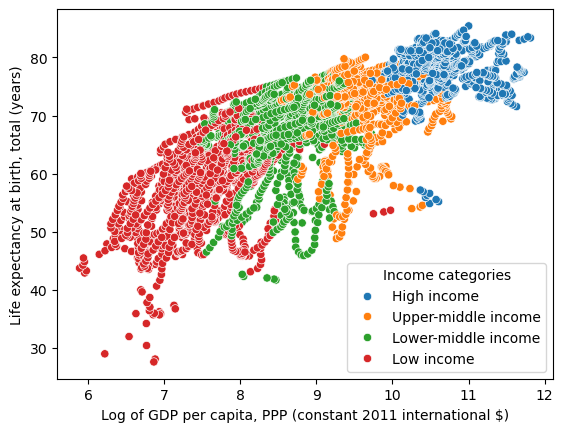

In [8]:
#Scatter plot 
legend_order = ["High income", "Upper-middle income", "Lower-middle income", "Low income"]
sns.scatterplot(x="lgdp_2011", y="life_exp", data=combined_data, hue="inc_cat", hue_order = legend_order)
plt.xlabel("Log of GDP per capita, PPP (constant 2011 international $)")
plt.ylabel("Life expectancy at birth, total (years)")
plt.legend(title="Income categories")
plt.show()


Creating graph using lists

Text(8.3, 55.5, 'Nigeria')

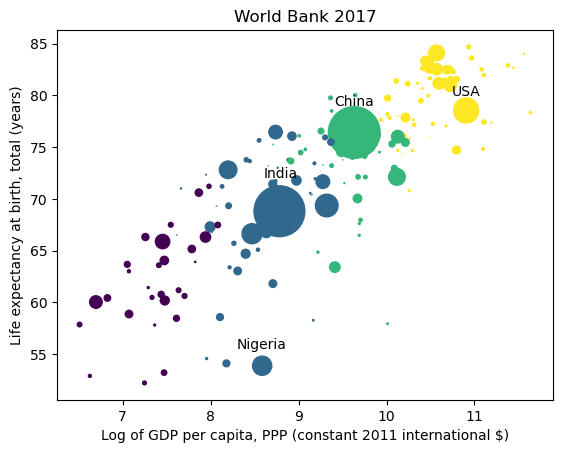

In [9]:
country = list(combined_data[combined_data["year"] == 2017]["country_code"])
lgdp = list(combined_data[combined_data["year"] == 2017]["lgdp_2011"])
life_exp = list(combined_data[combined_data["year"] == 2017]["life_exp"])
pop = list(combined_data[combined_data["year"] == 2017]["pop"])
inc_cat = list(combined_data[combined_data["year"] == 2017]["inc_cat"])
pop = np.array(pop)/1000000

income_mapping = {
    'Low income': 1,
    'Lower-middle income': 2,
    'Upper-middle income': 3,
    'High income': 4
}
colors = [income_mapping[level] for level in inc_cat]


plt.scatter(x=lgdp, y=life_exp, s = np.array(pop), c=colors)
plt.xlabel("Log of GDP per capita, PPP (constant 2011 international $)")
plt.ylabel("Life expectancy at birth, total (years)")
plt.title("World Bank 2017")

plt.text(9.4, 79, "China")
plt.text(8.6, 72, "India")
plt.text(10.74, 80, "USA")
plt.text(8.3, 55.5, "Nigeria")